# Téléchargement de périodiques sur Gallica

Ce carnet permet de télécharger les pages des parutions de périodiques Gallica au format JPG, ou l'ensemble des parutions aux formats PDF ou TXT, à partir des identifiants ark des documents. 

Téléchargement des pages des documents au format JPG ou de l'ensemble du document au format PDF ou TXT.

Les périodiques sont définis par leur identifiant ark (ex : cb32701734b).

Il est possible de télécharger pour chaque périodique une ou plusieurs année(s) en définissant un intervalle :


**Intervalles possible :** 

une année = **1894**

un intervalle d'années = **1894-1902** (9 années)

certaines années = **1894;1897;1911;1878** (pas de nombre maximum d'années)

Laisser vide signifie la totalité des parutions


**Télécharger plusieurs périodiques à partir d'un fichier tableur :**

Pour télécharger plusieurs périodiques, spécifier dans la dernière cellule  le chemin absolu vers un fichier xls contenant au minimum une colonne sans titre listant les liens Gallica des documents, et une colonne sans titre contenant les indications d'intervalles temporels à télécharger.

Les colonnes sont ensuite précisées par leur indice (ex : A)


***Exemple de fichier :*** 

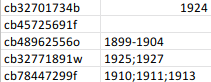

In [ ]:
#@title ##  Préparation

#@markdown ### Lancer cette cellule en préambule
#@markdown Puis cliquer sur le lien généré pour synchroniser un compte Google Drive si demandé


try :
    import xmltodict
except ModuleNotFoundError :
    !pip -q install xmltodict
import shutil
import requests
import xmltodict
from bs4 import BeautifulSoup
from openpyxl import load_workbook
import urllib.request, urllib.error, urllib.parse
from urllib.error import HTTPError, URLError
from xml.etree import ElementTree as ET
from google.colab import drive
import os
import json
import unicodedata
import re
from tqdm import tqdm

# Chargement d'un google drive
if not os.path.exists("/content/drive/MyDrive/") :
    drive.mount('/content/drive/')

# Définition des fonctions
def issues_year(id):
    ISSUES_BASEURL = 'https://gallica.bnf.fr/services/Issues?ark=ark:/12148/'
    url = "".join([ISSUES_BASEURL, id, '/date'])
    annees = []
    s = requests.get(url, stream=True)
    soup = BeautifulSoup(s.content,"lxml-xml")
    for tag in soup.findAll('year'):
        annee = ''.join(tag.findAll(text=True)) 
        annees.append(annee)
    return annees

def issues_month(id, annee):
    numeros = {}
    ISSUESDATE_BASEURL = 'https://gallica.bnf.fr/services/Issues?ark=ark:/12148/'
    url = "".join([ISSUESDATE_BASEURL, id, '/date&date=', str(annee)])
    s = requests.get(url, stream=True)
    soup = BeautifulSoup(s.content,"lxml-xml")
    for tag in soup.findAll('issue'):
        date = ''.join(tag.findAll(text=True)) 
        ark = tag["ark"]
        numeros[ark] = date
    return numeros

def scrap(ark, titre, intervalle, taille_images) :
  annes_dispo = issues_year(ark)
  if len(intervalle) == 4 :
    if intervalle in annes_dispo :
      annees = [intervalle]
    else :
      annees = []
  elif "-" in intervalle :
    annee_min = int(intervalle.split("-")[0])
    annee_max = int(intervalle.split("-")[-1])+1
    annees = [annee for annee in range(annee_min, annee_max) if str(annee) in annes_dispo ]
  elif len(intervalle) < 2 :
    annees = issues_year(ark)
  elif ";" in intervalle :
    annees = [annee for annee in intervalle.split(";") if str(annee) in annes_dispo]

  else :
    print("L'intervalle ne peut pas être interprété'") 

  print("Années disponibles dans l'intervalle demandé : ", annees)
  for annee in annees :
    annee = str(annee)
    print("Année {} : ".format(annee))
    if not os.path.exists(annee):
      os.makedirs(annee)
    os.chdir(annee) 
    dict_numeros = issues_month(ark, annee)
    if len(dict_numeros) == 0 :
      print("Aucun numéro disponible pour cette année")
    else : 
      print("Nombre de numéros disponibles pour l'année {} : {}".format(annee, len(dict_numeros)))
    for num in dict_numeros.keys():
      date = dict_numeros[num]
      print("Numéro : {} ({})".format(date, num))
      mois = date.split(" ")[1]
      jour = date.split(" ")[0]

      if mois :
        if not os.path.exists(mois):
          os.makedirs(mois)
        os.chdir(mois) 
        mois_yn = "y"
        if jour :
          if not os.path.exists(jour):
            os.makedirs(jour)
          os.chdir(jour) 
          jour_yn = "y"
        else :
          jour_yn = ""
      else : 
        jour_yn = ""
        mois_yn = ""
      
      
      pagination, nb_pages = paginationDL(num)
      print("Nombre de pages : ", str(nb_pages))
      print()

      if format_telechargement == "jpg" :
        for page in tqdm(range(nb_pages)) :
          page += 1
          #print("Page {0}/{1}".format(str(page), str(nb_pages)))
          ordre, numero = page_courante(num, page, pagination)
          reponse_alto = altoDL(num,page, ordre, numero, titre, annee, mois, jour)
          if reponse_alto =="yes" :
            pass
          if reponse_alto == "no" :
            sans_ocr.append(num)
            print("OCR indisponible")
          reponse_doc = pageDL(num, page, ordre, numero, taille_images, titre, annee, mois, jour)
          if reponse_doc == "ok" :
            pass
          if reponse_doc == "500" :
            #erreurs_500.append(num)
            print()
            print("Le document {} n'a pas pu être téléchargé : Erreur 500, erreur interne du serveur".format(num))
            pass
          else : pass
      elif format_telechargement == "txt" :
        txtDL(num, nb_pages, titre, annee, mois, jour)

      elif format_telechargement == "pdf" :
        pdfDL(num,titre, annee, mois, jour)

      if jour_yn :
        os.chdir("../..") 
      elif mois_yn :
        os.chdir("..") 
    os.chdir("..") 


def remove_accents(s):
  return ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))

def normalisation_titre(titre):
  titre = remove_accents(titre)
  titre = re.sub('[^a-zA-Z0-9- ]', '', titre)
  titre = re.sub('[ ]', '_', titre)
  return "_".join(titre.split("_")[:6])

def get_title(ark):
  url_biblio = "https://gallica.bnf.fr/services/OAIRecord?ark="+ark
  s = requests.get(url_biblio, stream=True)
  bibliodico = xmltodict.parse(s.text)
  try :
    titre = bibliodico["results"]["title"]
    titre = normalisation_titre(titre)
  except :
    titre = ark
  return titre
     

def paginationDL(ark):
    try :
        PAGINATION_BASEURL = 'https://gallica.bnf.fr/services/Pagination?ark='
        url = "".join([PAGINATION_BASEURL, ark])
        s = requests.get(url, stream=True)
        pagination = str(BeautifulSoup(s.content,"lxml-xml"))
        paginationdic = xmltodict.parse(pagination)
        nb_pages = int(paginationdic["livre"]["structure"]["nbVueImages"])
        with open("pagination_"+str(ark), "w") as pagout :
            pagout.write(pagination)
        return paginationdic, nb_pages
    except :
        print("la pagination n'a pas été téléchargée")
        


def altoDL(ark,page, ordre, numero, titre, annee, mois, jour):
    
    OCR_BASEURL = 'https://gallica.bnf.fr/RequestDigitalElement?O='
    url = "".join([OCR_BASEURL, ark, '&E=ALTO&Deb=', str(page)])
    s = requests.get(url, stream=True)
    alto = str(BeautifulSoup(s.content,"lxml-xml"))
    nom_fichier = titre+"_"+ark+"_"+annee+"_"+mois+"_"+jour+"_"+"view_"+str(ordre)+"_num_"+str(numero)+".xml"
    with open(nom_fichier, "w") as altout :
        altout.write(alto)
    if len(alto) < 40 :
        return "no"
    else :
        return "yes"


def pageDL(ark, page, ordre, numero, taille_images, titre, annee, mois, jour, region="full", rotation="0", quality="native", format="jpg"):

    # Télécharge l'image de la page souhaitée dans le dossier courant
    # input : ark : string page: string ou float
    # output page_X.jpg dans le dossier courant
    
    IIIF_BASEURL = 'https://gallica.bnf.fr/iiif/ark:/12148/'
    url = "".join([IIIF_BASEURL, ark, '/f', str(page), '/', region, '/', taille_images, '/', rotation, '/', quality, '.', format])
    nom_fichier = titre+"_"+ark+"_"+annee+"_"+mois+"_"+jour+"_"+"view_"+str(ordre)+"_num_"+str(numero)+".jpg"
    try :
        urllib.request.urlretrieve(url, nom_fichier)
        return "ok"
    except (HTTPError, URLError) as erreur:
        return str(erreur.reason)        



def page_courante(ark, page, pagination):
    ordre = pagination["livre"]["pages"]["page"][int(page-1)]["ordre"]
    numero = pagination["livre"]["pages"]["page"][int(page-1)]["numero"]
    return ordre, numero

def norm_intervalle(intervalle):
  if isinstance(intervalle, str)  :
    intervalle = intervalle.strip()
    if "." in intervalle :
      intervalle = intervalle[:-2]
    if intervalle == "None" :
      intervalle = "0"
  elif isinstance(intervalle, float) :
    intervalle = str(int(intervalle))
  elif isinstance(intervalle, int) :
    intervalle = str(intervalle)
  return intervalle



def pdfDL(ark,titre,annee,mois,jour):
  try :
    url = "https://gallica.bnf.fr/ark:/12148/"+str(ark)+".pdf"
    nom_fichier = ark+"_"+titre+"_"+annee+"_"+mois+"_"+jour+".pdf"
    urllib.request.urlretrieve(url, nom_fichier)
  except :
    print("Le pdf n'a pas pu être téléchargé")

def txtDL(ark, nb_pages, titre, annee, mois, jour):
  try :
    url = "https://gallica.bnf.fr/ark:/12148/"+str(ark)+"/f1n"+str(nb_pages)+".texteBrut"
    print(url)
    nom_fichier = ark+"_"+titre+"_"+annee+"_"+mois+"_"+jour+".txt"
    page = urllib.request.urlopen(url).read().decode('utf-8')
    page = str(page)
    soup = BeautifulSoup(page, "html.parser")
    p_tags = soup.find_all("p")
    with open(nom_fichier, 'w') as f:
      for tag in p_tags:
        f.write(str(tag.text)+'\n')
  except :
    print("Le texte du document {} n'a pas pu être téléchargé".format(ark))

In [ ]:

telechargement = "txt"

#@markdown ## Télécharger un seul périodique
#@markdown Renseigner les paramètres avant de lancer la cellule

#@markdown ---

#@markdown #### Entrez l'identifiant ARK d'un périodique à télécharger :
ark = "" #@param {type:"string"}
#@markdown Exemple d'identifiant : cb32701734b

#@markdown ---

#@markdown #### Entrez l'intervalle des années à télécharger pour ce périodique :
intervalle = "" #@param {type:"string"}
#@markdown Voir les indications plus haut

#@markdown ---

#@markdown #### Entrez le répertoire de destination où télécharger le périodique :
chemin_destination = "/content" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/My Drive/datasets/

#@markdown ---

#@markdown #### Choisir le format de téléchargement :
format_telechargement = "jpg" #@param ["jpg", "txt", "pdf"]
#@markdown  Télécharge un fichier par page au format jpg et un fichier pour l'ensemble du document autrement


#@markdown ---

#@markdown #### Réduction de la taille des images téléchargées :

#@markdown (Si format jpg, ignorer autrement)

#@markdown Déplacer le curseur pour sélectionner un pourcentage de la taille initiale des images à télécharger

#@markdown Le ratio hauteur/largeur est conservé

taille_images = 100 #@param {type:"slider", min:0, max:100, step:10}
if taille_images == 100 :
  taille_images = "full"
else :
  taille_images = "pct:"+str(taille_images)
  size = taille_images


print("Dossier de destination : ", chemin_destination)
if not os.path.exists(chemin_destination) :
  os.makedirs(chemin_destination)
os.chdir(chemin_destination)


#try :
titre_doc = get_title(ark)
if not os.path.exists(titre_doc):
  os.makedirs(titre_doc)
os.chdir(titre_doc)
print("*** ", titre_doc, " ***")
print("Identifiant du document : ", ark)
intervalle = norm_intervalle(intervalle)
print("Intervalle repéré : ", intervalle)

scrap(ark, titre_doc, intervalle, taille_images)
os.chdir(chemin_destination)



In [ ]:

#@markdown ## Télécharger plusieurs périodiques référencés dans un fichier tableur
#@markdown Renseigner les paramètres avant de lancer la cellule

#@markdown ---

#@markdown #### Entrez le chemin du fichier xls (xlsx ou xlsm) :
chemin_fichier_xls = "" #@param {type:"string"}

#@markdown Possibilité de copier/coller le chemin depuis la fenêtre de gauche : onglet "Fichiers" -> clic droit sur un dossier -> "Copier le chemin"

#@markdown Exemple de chemin:
#@markdown /content/drive/My Drive/fichiers/

#@markdown ---

#@markdown #### Entrez l'indice de la colonne contenant les liens ARK :
colonne_ark = "" #@param {type:"string"}
#@markdown Exemple d'indice : A

#@markdown ---

#@markdown #### Entrez l'indice de la colonne contenant les intervalles à télécharger :
colonne_intervalles = "" #@param {type:"string"}
#@markdown Exemple d'indice : B

#@markdown ---

#@markdown #### Entrez le répertoire de destination où télécharger les documents :
chemin_destination = "" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/My Drive/datasets/

#@markdown ---

#@markdown #### Choisir le format de téléchargement :
format_telechargement = "jpg" #@param ["jpg", "txt", "pdf"]
#@markdown  Télécharge un fichier par page au format jpg et un fichier pour l'ensemble du document autrement


#@markdown ---

#@markdown #### Réduction de la taille des images téléchargées :
#@markdown (Si format jpg, ignorer autrement)

#@markdown Déplacer le curseur pour sélectionner un pourcentage de la taille initiale des images à télécharger

#@markdown Le ratio hauteur/largeur est conservé

taille_images = 100 #@param {type:"slider", min:0, max:100, step:10}
if taille_images == 100 :
  taille_images = "full"
else :
  taille_images = "pct:"+str(taille_images)
  size = taille_images

chemin_classeur = chemin_fichier_xls

print("Lecture du fichier xls :")
try :
  if not os.path.exists(chemin_destination):
      os.makedirs(chemin_destination)
except :
  print("Le chemin de destination est incorrect")

arks_doc = []
intervalles = []

# Chargement du fichier xls
try :
  classeur= load_workbook(chemin_classeur)
except :
  print("Le fichier xls n'a pas été chargé correctement")

for onglet in classeur.sheetnames:
    onglet_courant = classeur[onglet]
    colonne = onglet_courant[colonne_ark]
    for cellule in colonne :
        if str(cellule.value).startswith("http") or str(cellule.value).startswith("ark") or str(cellule.value).startswith("cb"):
            arks_doc.append(str(cellule.value))

    colonne = onglet_courant[colonne_intervalles]
    for cellule in colonne :
        intervalles.append(str(cellule.value))

print("{0} liens récupérés dans {1} onglets".format(len(arks_doc), len(classeur.sheetnames)))

arks_doc = [ark.split("/")[-1].strip() for ark in arks_doc]

arks_intervalles = {}
for i in range(len(arks_doc)):
  dic = {arks_doc[i] : intervalles[i]}
  arks_intervalles[i] = dic

print("Dossier de destination : ", chemin_destination)
os.chdir(chemin_destination)

erreurs_500 = []
sans_ocr = []
introuvables = []

for i in arks_intervalles.values() :
  for document, intervalle in i.items() :
    try :
      titre_doc = get_title(document)
      if not os.path.exists(titre_doc):
        os.makedirs(titre_doc)
      os.chdir(titre_doc)
      print("*** ", titre_doc, " ***")
      print("Identifiant du document : ", document)
      intervalle = norm_intervalle(intervalle)
      print("Intervalle repéré : ", intervalle)

      scrap(document,titre_doc, intervalle, taille_images)
      os.chdir(chemin_destination)
    except : 
      print("Le document est introuvable")
      introuvables.append(document)
erreurs_500 = set(erreurs_500)
with open("erreurs_500.txt", "w") as err :
  err.write("=============================")
  err.write("Erreurs 500 : ")
  err.write("=============================")
  for ark in erreurs_500 :
    err.write(ark)
    err.write("\n")
  err.write("=============================")
  err.write("Documents non-océrisés : ")
  err.write("=============================")
  for ocrless in sans_ocr :
    err.write(ocrless)
  err.write("=============================")
  err.write("Documents introuvables : ")
  err.write("=============================")
  for introuvable in introuvables :
    err.write(introuvable)
  
  
print("Documents non téléchargés (erreur 500) : {0}".format(len(erreurs_500)))
print("Ces documents sont listés dans le fichier erreurs_500.txt")

